In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import cv2

In [2]:
from math import pi, exp
def gaussian_pdf_2D(x, y, sigma=1):
    exp_term = -(x*x + y*y) / (2.*sigma*sigma)
    const_term = 1/(2*pi*(sigma**2))
    return const_term * exp(exp_term)

def get_gaussian_filter(kernel_size=(3,3), sigma=1):
    if type(kernel_size) == type(1):
        m = n = kernel_size
    else:
        m, n = kernel_size
    if (m%2 != 1) or (n%2 != 1):
        raise Exception("Kernel size must be odd ", kernel_size)
    gaussian_kernel = np.zeros((m,n))
    center_x = (n+1) // 2 -1
    center_y = (m+1) // 2 -1
    for u in range(n):
        for v in range(m):
            gaussian_kernel[v, u] = gaussian_pdf_2D(u-center_x, v-center_y, sigma)
    gaussian_kernel /= gaussian_kernel.sum()
    return gaussian_kernel

In [3]:
def zero_padding(img, size=(1,1)):
    if type(size) == type(1):
        oy = ox = size
    else:
        oy, ox = size
    m, n = img.shape
    img_pad = np.zeros((m+2*oy, n+2*ox))
    img_pad[oy:-oy, ox:-ox] = img
    return img_pad
    

def convolution_2D(img, filter, padding=True):
    if len(img.shape) != 2:
        raise Exception("Only support gray image right now !", img.shape)
    m, n = img.shape
    p, q = filter.shape
    
    ox = (q-1)//2
    oy = (p-1)//2
    if padding:
        img = zero_padding(img, size=(oy,ox))
        m, n = img.shape
    
    output_img = np.zeros((m, n))
    for cy in range(oy, m-oy):
        for cx in range(ox, n-ox):
            img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
            output_img[cy, cx] = np.sum(img_window*filter)
            
    output_img = output_img[oy:-oy, ox:-ox]
    return output_img

In [4]:
def subsampling(img, size=(64,64)):
    if len(img.shape) != 2:
        raise Exception("Only support gray image right now !", img.shape)
    m, n = img.shape
    sy = (m-1)/(size[0]-1)
    sx = (n-1)/(size[1]-1)
    img_sub = np.zeros(size)
    for row in range(size[0]):
        for col in range(size[1]):
            img_sub[row][col] = img[int(row*sy)][int(col*sx)]
    return img_sub

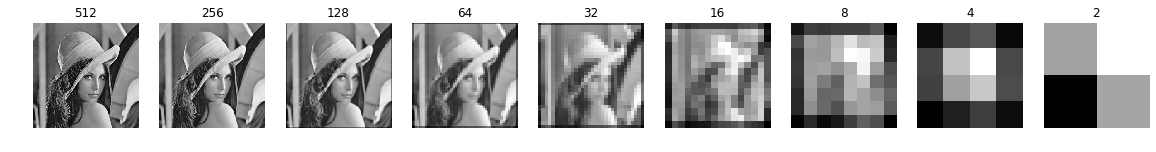

In [5]:
# Image Pyramid
img = cv2.imread("datas/lena.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

img_pyramid = {}
gaussian_filter = get_gaussian_filter(kernel_size=(3,3), sigma=1)
pyramid_size = [512, 256, 128, 64, 32, 16, 8, 4, 2]
img_pyramid[pyramid_size[0]] = cv2.resize(img_gray, (pyramid_size[0], pyramid_size[0]))

for s in pyramid_size[1:]:
    size =(s, s)
    img = img_pyramid[s*2]
    img_smooth = convolution_2D(img, gaussian_filter)
    img_sub = subsampling(img_smooth, size)
    img_pyramid[s] = img_sub

num_imgs = len(pyramid_size)

plt.figure(figsize = (20,10))
for i, s in enumerate(pyramid_size):
    plt.subplot(1, num_imgs, i+1), plt.axis('off'), plt.title(s), plt.imshow(img_pyramid[s], cmap='gray')
plt.show()

In [ ]:
# Todo: Laplacian Pyramid 